In [57]:
from rich import print
from rich import pretty
pretty.install()
from icecream import ic
from rich.console import Console
console = Console()
from IPython.display import Markdown

import os
from pathlib import Path
import pathlib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K 
from tensorflow.keras import losses
from scipy.stats import norm


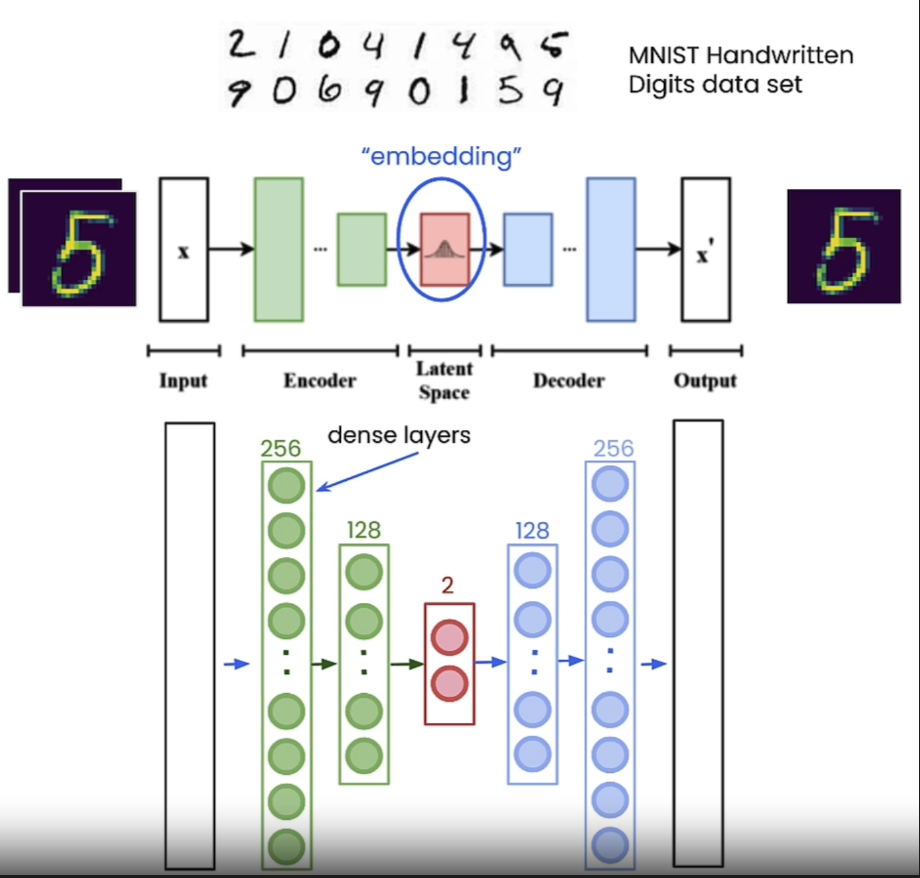{:width='500px'}

In [5]:
# Load data – training and test
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

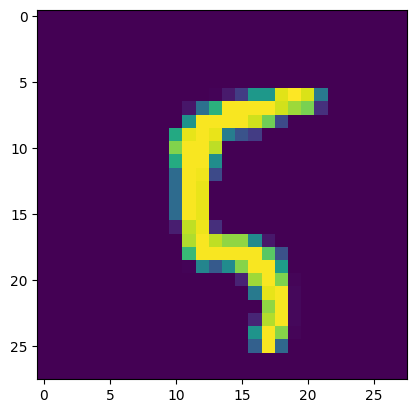

In [6]:
# lets view one of the images
plt.imshow(x_tr[100])

In [7]:
def print_shape(X_train = x_tr, y_train = y_tr, X_test = x_te, y_test = y_te):
    print(f"""
    The shape of X_train is {X_train.shape}\n
    The shape of y_train is {y_train.shape}\n
    The shape of X_test is {X_test.shape}\n
    The shape of y_test is {y_test.shape}\n
    """)
    return None

In [8]:
print_shape()

The shape of X_train is (60000, 28, 28)

    The shape of y_train is (60000,)

    The shape of X_test is (10000, 28, 28)

    The shape of y_test is (10000,)

In [9]:
# normalize the image pixel to between 0 - 255 and reshape the array to a 2-dimensional array
#Normalize and Reshape images (flatten)
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

print_shape(x_tr_flat, y_tr, x_te_flat, y_te)



The shape of X_train is (60000, 784)

    The shape of y_train is (60000,)

    The shape of X_test is (10000, 784)

    The shape of y_test is (10000,)

In [10]:
# create a sampling function to be able to grab number of images randomly during training.
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

In [11]:
# set the network parameters
# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2

In [12]:
# Encoder - from 784->256->128->2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer

# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

In [13]:
#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)

In [14]:
# variational autoencode (VAE) - to reconstruction input
reconstruction_loss = losses.binary_crossentropy(
    inputs_flat,
    outputs_flat) * x_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(
    K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat -1 , axis = -1)

vae_flat_loss = reconstruction_loss + kl_loss

# Build model
# ensure that the reconstructed ouputs are as close to the inputs as possible
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer = 'adam')

In [15]:
# train
vae_flat.fit(
    x_tr_flat,
    shuffle=True,
    epochs=n_epoch,
    batch_size=batch_size,
    validation_data=(x_te_flat, None),
    verbose=1
)

Epoch 1/50
600/600 [==============================] - 5s 7ms/step - loss: 192.0640 - val_loss: 168.4594
Epoch 2/50
600/600 [==============================] - 4s 6ms/step - loss: 164.3960 - val_loss: 161.0089
Epoch 3/50
600/600 [==============================] - 4s 6ms/step - loss: 158.6346 - val_loss: 156.4695
Epoch 4/50
600/600 [==============================] - 4s 6ms/step - loss: 154.8225 - val_loss: 153.1839
Epoch 5/50
600/600 [==============================] - 4s 6ms/step - loss: 151.7544 - val_loss: 150.5213
Epoch 6/50
600/600 [==============================] - 4s 6ms/step - loss: 149.2976 - val_loss: 148.6340
Epoch 7/50
600/600 [==============================] - 4s 6ms/step - loss: 147.3898 - val_loss: 147.0685
Epoch 8/50
600/600 [==============================] - 4s 6ms/step - loss: 145.9528 - val_loss: 145.5811
Epoch 9/50
600/600 [==============================] - 4s 6ms/step - loss: 144.7023 - val_loss: 144.7047
Epoch 10/50
600/600 [==============================] - 4s 6ms/st

<keras.src.callbacks.History object at 0x7f0f27137370>

In [16]:
# Build encoders
encoder_f = Model(inputs_flat, z_flat)  # flat encoder

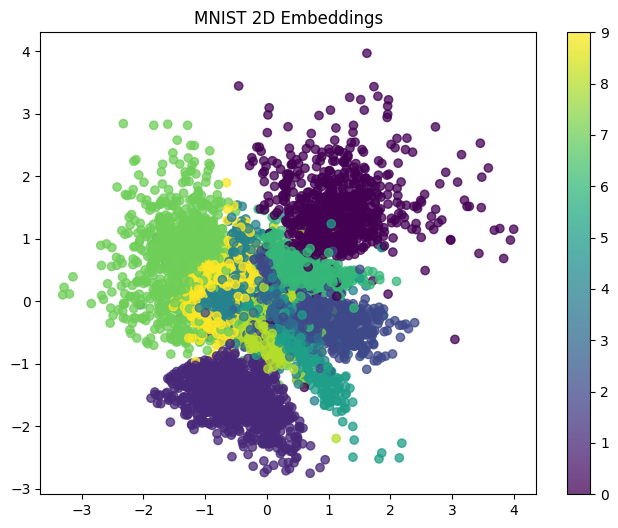

In [17]:
# Plot of the digit classes in the latent space
x_te_latent = encoder_f.predict(x_te_flat, batch_size=batch_size,verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()

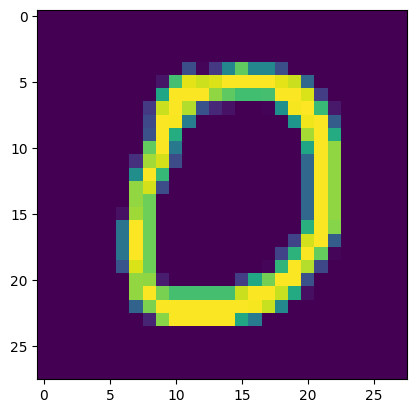

In [18]:
# let us now compare vector embedding
plt.imshow(x_te_flat[10].reshape(28, 28))

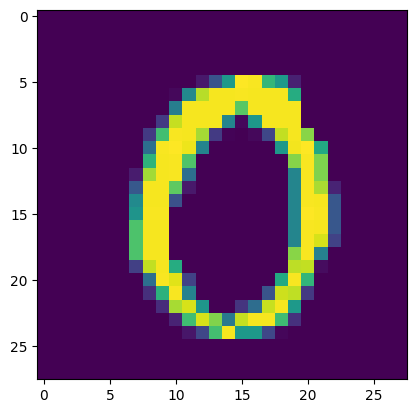

In [24]:
plt.imshow(x_te_flat[13].reshape(28,28));

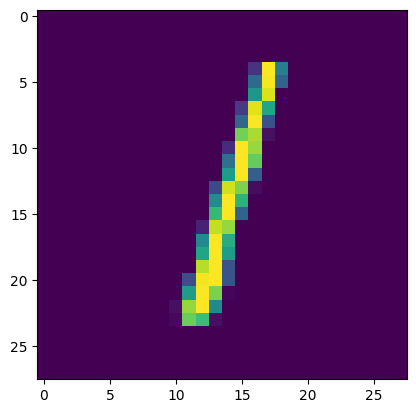

In [20]:
plt.imshow(x_te_flat[2].reshape(28,28));

In [28]:
# lookup vectors for each digits
zero_A = x_te_latent[10]
zero_B = x_te_latent[13]
one = x_te_latent[2]

print(f"Embedding for the first ZERO is  {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is         {one}")

Embedding for the first ZERO is  [0.83312315 1.2641102 ]

Embedding for the second ZERO is [0.6665005 1.0235324]

Embedding for the ONE is         [-0.48709142 -1.9574659 ]